<a href="https://colab.research.google.com/github/daspillegh/DavidPilhofer_TFE21-2_DeepDive/blob/main/DavidPilhoferDeepDiveAbgabe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modell für die Hausarbeit in DeepLearning

In [2]:

# Install packages for binder usage
%pip install scikit-learn
%pip install tensorflow
%pip install matplotlib
%pip install seaborn

# Importing all the good stuff!
from IPython.display import display, clear_output
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import tensorflow as tf
from tensorflow.keras import callbacks
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model
from google.colab import files


x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)

 Plot of the first 25 samples in the MNIST training set


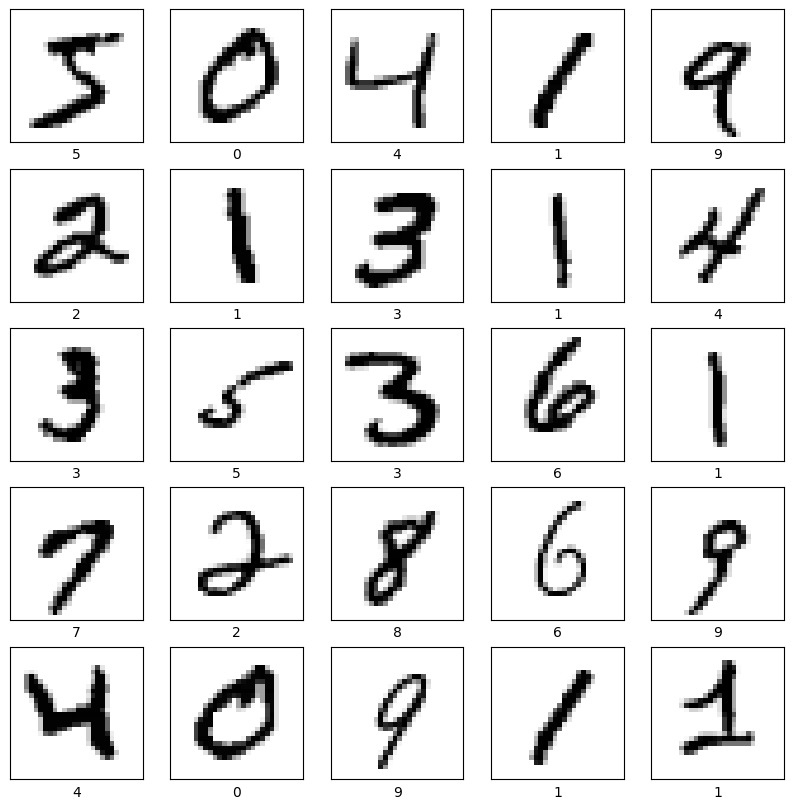

In [48]:
# Loading the MNIST dataset in one line
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Printing the shape
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

# Plotting data samples
print('\n Plot of the first 25 samples in the MNIST training set')
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10,10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

augmented_x_train: (30000, 28, 28)
augmented_y_train: (30000,)
x_test (10000, 28, 28)
y_test (10000,)

 Plot of the first 10 samples of augmented data


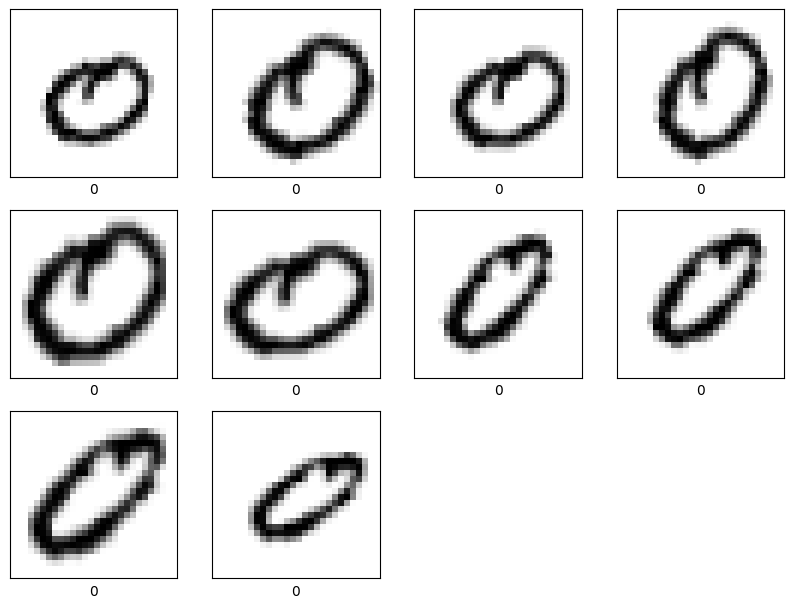

In [49]:
# Reduce the dataset and augment the data

# Function to reduce and augment the datasamples
def reduce_and_augment_data(x, y, num_samples_per_class, augmentation_factor=6):
    reduced_x = []
    reduced_y = []

    unique_labels = np.unique(y)

    for label in unique_labels:
        indices = np.where(y == label)[0]
        selected_indices = np.random.choice(indices, num_samples_per_class, replace=False)

        # Reduced x and y train
        reduced_x.extend(x[selected_indices])
        reduced_y.extend(y[selected_indices])


    # Augment the reduced data
    augmented_x, augmented_y = augment_data(reduced_x, reduced_y, augmentation_factor)

    return np.array(augmented_x), np.array(augmented_y)

# Define function to augment data
def augment_data(x, y, augmentation_factor):
    augmented_data = []
    augmented_labels = []

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.2,
        fill_mode='constant',
        cval=0,
        vertical_flip=False,
        horizontal_flip=False,
    )

    for img, label in zip(x, y):
        img = img.reshape((1,) + img.shape + (1,))
        label = np.array([label])

        i = 0
        for batch, labels in datagen.flow(img, label, batch_size=1):
            augmented_data.append(batch[0].reshape(img.shape[1: -1]))
            augmented_labels.append(labels[0])
            i += 1
            if i >= augmentation_factor:
                break

    return augmented_data, augmented_labels

# Define the number of samples per class
num_samples_per_class = 500

# Call the function to reduce and augment the data
augmented_x_train, augmented_y_train = reduce_and_augment_data(x_train, y_train, num_samples_per_class)

# Print the size to check if reduction and augmentation worked
print('augmented_x_train:', np.array(augmented_x_train).shape)
print('augmented_y_train:', np.array(augmented_y_train).shape)
print('x_test',np.array(x_test).shape)
print('y_test',np.array(y_test).shape)

# Plotting the first data samples of augmented data
print('\n Plot of the first 10 samples of augmented data')
numbers_to_display = 10
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10,10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(augmented_x_train[i], cmap=plt.cm.binary)
    plt.xlabel(augmented_y_train[i])
plt.show()


y_train = augmented_y_train

x_train_normalized = augmented_x_train /255
x_test_normalized = x_test/255

x_train= x_train_normalized.reshape(-1, 28, 28, 1)
x_test = x_test_normalized.reshape(-1, 28, 28, 1)


In [ ]:
#Plotting a specific label

#plt.imshow(x_train[99][:,:,0])
#print(y_train[99])

In [50]:
# Define the architecture of the model

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [51]:
# Print the summary of your defined model

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 flatten_5 (Flatten)         (None, 5408)              0         
                                                                 
 dense_10 (Dense)            (None, 64)                346176    
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                      

In [52]:
# Define your loss

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


print(-tf.math.log(1/10))

sampleID = 100
loss_fn(y_train[:1], model(x_train[sampleID-1:sampleID]).numpy()).numpy()


tf.Tensor(2.3025851, shape=(), dtype=float32)


2.3157983

In [53]:
# Compile your model

model.compile(optimizer='adam',
              loss= loss_fn ,
              metrics=['accuracy'])

In [54]:
# Define early stopping callback on validation loss
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=False,
)

# Reduce learning rate when validation loss plateaus
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4
)

# Safe the best weights of training
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    'DavidPilhoferDeepDive.h5',
                    monitor="val_accuracy",
                    mode="max",
                    save_best_only=True,
                    verbose=1
)


In [55]:
# Finally train your model

model.fit(
    x_train,
    y_train,
    epochs= 30,
    batch_size= 64,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


# Save model
model.save('DavidPilhoferDeepDive',save_format = 'h5')


Epoch 1/30
464/469 [============================>.] - ETA: 0s - loss: 0.5763 - accuracy: 0.8258
Epoch 1: val_accuracy improved from -inf to 0.96530, saving model to DavidPilhoferDeepDive.h5
469/469 [==============================] - 3s 4ms/step - loss: 0.5729 - accuracy: 0.8269 - val_loss: 0.1192 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 2/30
465/469 [============================>.] - ETA: 0s - loss: 0.2291 - accuracy: 0.9284
Epoch 2: val_accuracy improved from 0.96530 to 0.97550, saving model to DavidPilhoferDeepDive.h5
469/469 [==============================] - 2s 4ms/step - loss: 0.2293 - accuracy: 0.9284 - val_loss: 0.0839 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 3/30
461/469 [============================>.] - ETA: 0s - loss: 0.1651 - accuracy: 0.9495
Epoch 3: val_accuracy improved from 0.97550 to 0.97920, saving model to DavidPilhoferDeepDive.h5
469/469 [==============================] - 2s 4ms/step - loss: 0.1644 - accuracy: 0.9498 - val_loss: 0.0683 - val_accuracy: 0.9792 - lr:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

313/313 [==============================] - 1s 2ms/step


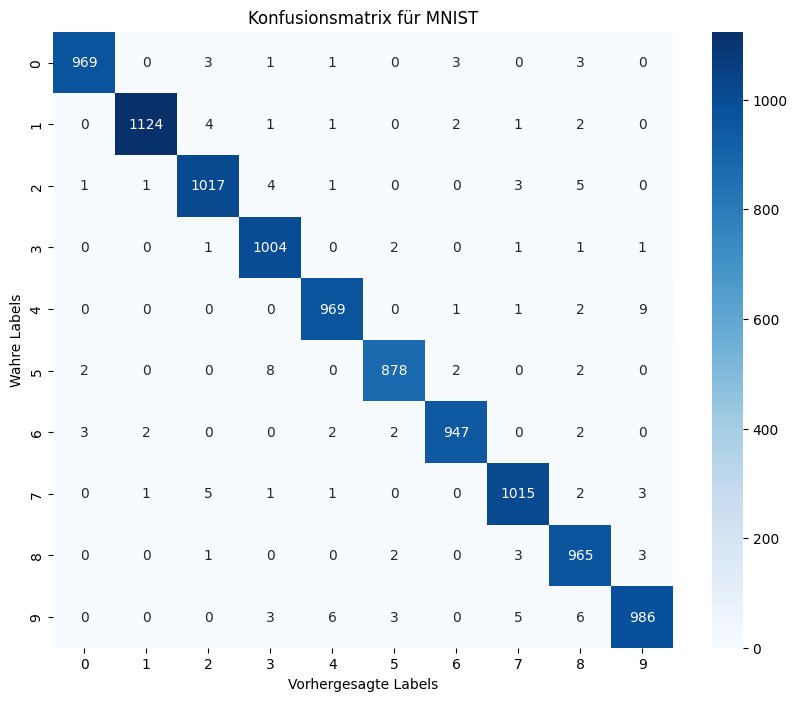

In [56]:
model = load_model('DavidPilhoferDeepDive.h5')
files.download('DavidPilhoferDeepDive.h5')

predictions = model.predict(x_test)
predicted_labels = tf.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, predicted_labels)

# Confusionmatrix to visualize the performance of your training
plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Konfusionsmatrix für MNIST')
plt.show()
